In [1]:
!pip install Pillow numpy scikit-image

C:\Users\pehfa\AppData\Local\Temp\ipykernel_12132\4281954685.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [1]:
import os
import glob
import pandas as pd

import matplotlib.pyplot as plt
import cv2
import numpy as np

from PIL import Image
import numpy as np
from skimage.restoration import denoise_wavelet
from skimage.filters import sobel
from skimage.exposure import equalize_adapthist
import skimage

from sklearn.model_selection import train_test_split

C:\Users\pehfa\AppData\Local\Temp\ipykernel_27228\941162035.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load Data

In [2]:
# The script is run from the root of the project directory
# Set the base path to the current working directory
#base_path = os.getcwd()

# Construct paths to 'real' and 'fake' directories
real_path = '../data/raw/face_real'
fake_path = '../data/raw/face_fake/1m_faces_00'

images_df = {
    "image_path":[],
    "label":[]
}

# Process real images
for subfolder in ['00000', '01000']:
    full_path = os.path.join(real_path, subfolder)
    for file_extension in ["*.jpg", "*.png"]:
        for img in glob.glob(os.path.join(full_path, file_extension)):
            images_df["image_path"].append(img)
            images_df["label"].append('real')
            
# Process fake images, limiting to 2000
count = 0
for file_extension in ["*.jpg", "*.png"]:
    for img in glob.glob(os.path.join(fake_path, file_extension)):
        if count < 2000:  # Limit to 2000 images
            images_df["image_path"].append(img)
            images_df["label"].append('fake')
            count += 1
        else:
            break

# Convert to DataFrame
images_df = pd.DataFrame(images_df)

In [3]:
# View the shape of the DataFrame (rows, columns)
shape = images_df.shape
print(f"Shape of the DataFrame: {shape}")

# Display the first few rows to inspect
print("First few rows of the DataFrame:")
print(images_df.head())

# Get a summary of the DataFrame
print("Summary of the DataFrame:")
print(images_df.info())

Shape of the DataFrame: (2000, 2)
First few rows of the DataFrame:
                         image_path label
0  ../data/raw/real\00000\00000.png  real
1  ../data/raw/real\00000\00001.png  real
2  ../data/raw/real\00000\00002.png  real
3  ../data/raw/real\00000\00003.png  real
4  ../data/raw/real\00000\00004.png  real
Summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2000 non-null   object
 1   label       2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None



# EDA

Total images: 4000
label
real    2000
fake    2000
Name: count, dtype: int64


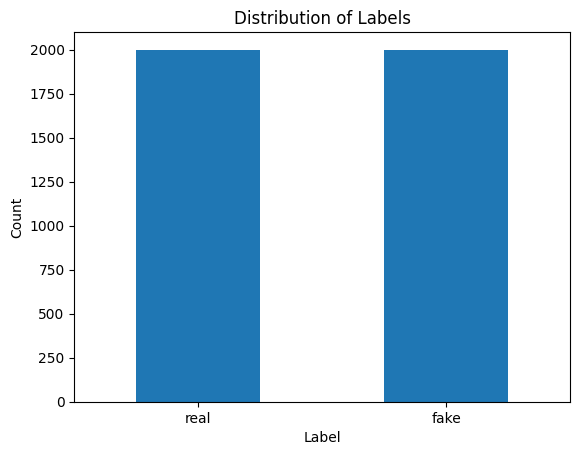

In [4]:
# Display basic dataset information
print(f"Total images: {len(images_df)}")
print(images_df['label'].value_counts())

# Plot the distribution of labels
images_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

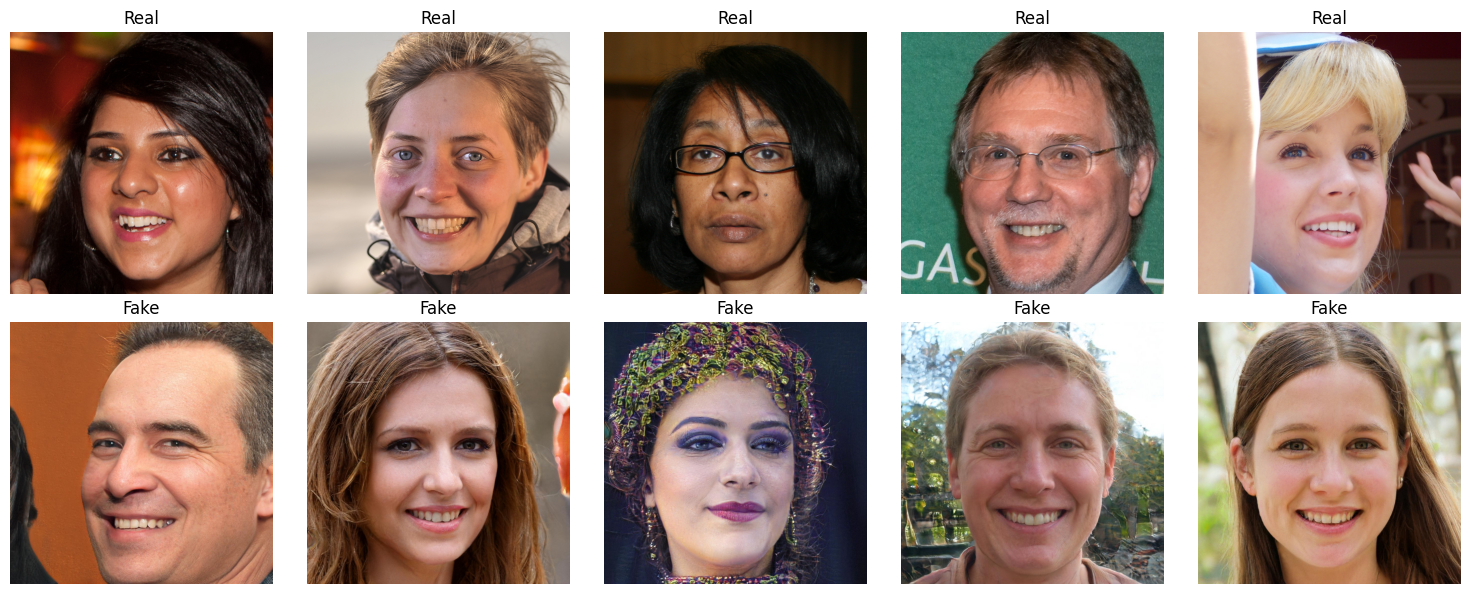

In [5]:
# Function to display images
def display_images(images, labels, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(labels[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Randomly select images to display
sample_real = images_df[images_df['label'] == 'real']['image_path'].sample(n=5).tolist()
sample_fake = images_df[images_df['label'] == 'fake']['image_path'].sample(n=5).tolist()

display_images(sample_real + sample_fake, ['Real']*5 + ['Fake']*5)

In [6]:
# Sample 10 random images from both real and fake categories
sample_real_paths = images_df[images_df['label'] == 'real']['image_path'].sample(n=10, random_state=1)
sample_fake_paths = images_df[images_df['label'] == 'fake']['image_path'].sample(n=10, random_state=1)

def check_image_dimensions(image_paths):
    dimensions = []
    for path in image_paths:
        img = cv2.imread(path)
        dimensions.append(img.shape[:2])  # Get height and width
    return dimensions

# Get dimensions for both real and fake image samples
real_dimensions = check_image_dimensions(sample_real_paths)
fake_dimensions = check_image_dimensions(sample_fake_paths)

print("Real Image Dimensions:")
print(real_dimensions)
print("\nFake Image Dimensions:")
print(fake_dimensions)

Real Image Dimensions:
[(1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024)]

Fake Image Dimensions:
[(1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024)]


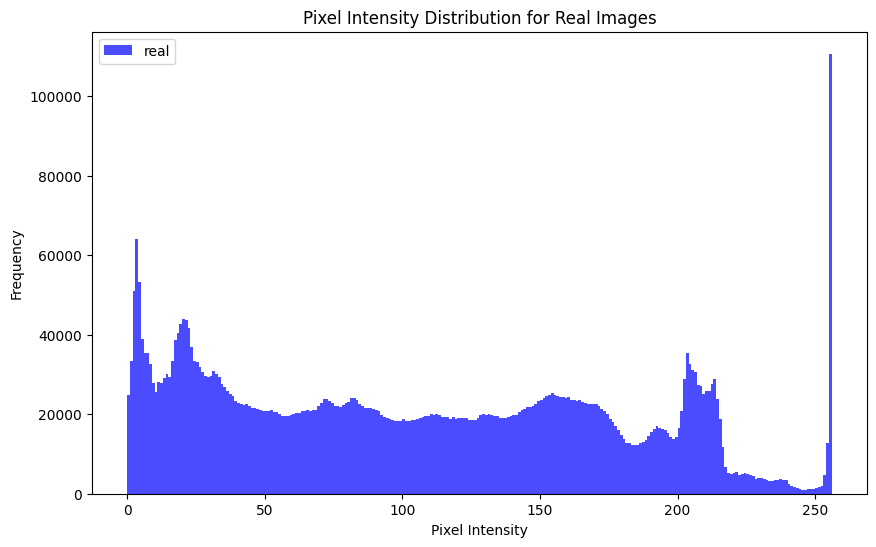

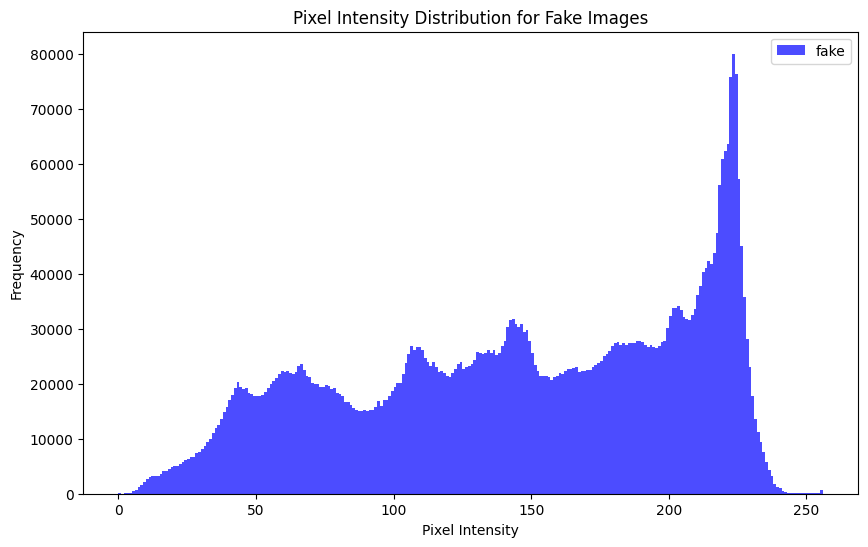

In [7]:
def plot_pixel_intensity_distribution(images_df, label, sample_size=5):
    # Filter the dataframe for the specified label and randomly select images
    sample_images = images_df[images_df['label'] == label]['image_path'].sample(n=sample_size).tolist()
    
    # Initialize a list to store pixel values
    pixel_values = []
    
    # Loop through the selected images
    for image_path in sample_images:
        # Read the image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Flatten the image array and add to the list of pixel values
        pixel_values.extend(img.flatten())
    
    # Plot the histogram of pixel intensities
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=256, range=(0,256), color='blue', alpha=0.7, label=label)
    plt.title(f'Pixel Intensity Distribution for {label.capitalize()} Images')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot pixel intensity distribution for real images
plot_pixel_intensity_distribution(images_df, 'real', sample_size=5)

# Plot pixel intensity distribution for fake images
plot_pixel_intensity_distribution(images_df, 'fake', sample_size=5)

In [11]:
'''
# Do not run this without a GPU - high computation

def plot_full_pixel_intensity_distribution(images_df, label):
    # Filter the dataframe for the specified label
    all_images = images_df[images_df['label'] == label]['image_path'].tolist()
    
    # Initialize a list to store pixel values
    pixel_values = []
    
    # Loop through all images
    for image_path in all_images:
        # Read the image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Flatten the image array and add to the list of pixel values
        pixel_values.extend(img.flatten())
    
    # Plot the histogram of pixel intensities
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=256, range=(0,256), color='blue', alpha=0.7, label=label)
    plt.title(f'Pixel Intensity Distribution for {label.capitalize()} Images')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot pixel intensity distribution for all real images
plot_full_pixel_intensity_distribution(images_df, 'real')

# Plot pixel intensity distribution for all fake images
plot_full_pixel_intensity_distribution(images_df, 'fake')
''''''

# Preprocessing

In [9]:
def resize_image(image: Image.Image, size: tuple[int, int] = (128, 128)) -> Image.Image:
    return image.resize(size)

def normalize_pixels(image_array: np.ndarray) -> np.ndarray:
    return image_array / 255.0

def convert_to_grayscale(image: Image.Image) -> Image.Image:
    return image.convert('L')

def denoise_image(image: np.ndarray) -> np.ndarray:
    # Assuming multichannel is based on the input image shape
    multichannel = image.shape[-1] == 3
    return denoise_wavelet(image, multichannel=multichannel, mode='soft')

def apply_edge_detection(image: np.ndarray) -> np.ndarray:
    return sobel(image)

def equalize_histogram(image: np.ndarray) -> np.ndarray:
    return equalize_adapthist(image, clip_limit=0.03)

def center_crop(image: Image.Image, crop_size: int) -> Image.Image:
    width, height = image.size
    left = (width - crop_size) / 2
    top = (height - crop_size) / 2
    right = (width + crop_size) / 2
    bottom = (height + crop_size) / 2
    return image.crop((left, top, right, bottom))

def standardize_image(image: np.ndarray, mean: float, std: float) -> np.ndarray:
    return (image - mean) / std

def to_numpy_array(image: Image.Image) -> np.ndarray:
    return np.array(image)

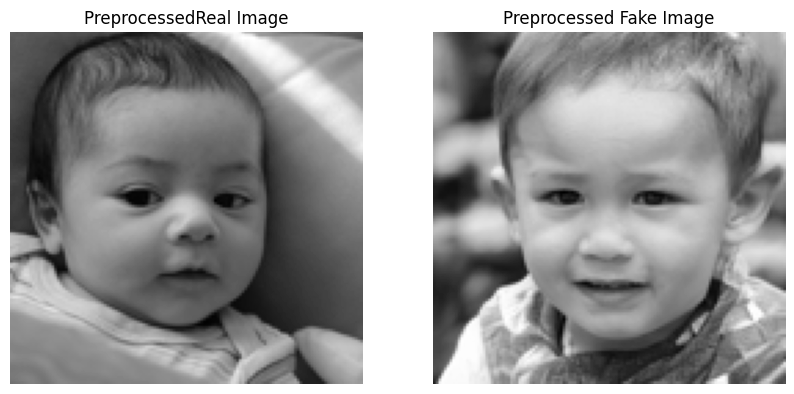

In [12]:
def preprocess_pipeline(image_path: str, size: tuple[int, int] = (128, 128), normalize: bool = True, 
                        to_grayscale: bool = False, denoise: bool = False, edge_detection: bool = False, 
                        equalize: bool = False, center_crop_size: int = None, 
                        standardize: bool = False, mean_std: tuple[float, float] = None) -> np.ndarray:
    try:
        with Image.open(image_path) as img:
            img = resize_image(img, size=size)
            
            if to_grayscale:
                img = convert_to_grayscale(img)
            
            img_array = to_numpy_array(img)
            
            if denoise:
                img_array = denoise_image(img_array)
            
            if edge_detection:
                img_array = apply_edge_detection(img_array)
            
            if equalize:
                img_array = equalize_histogram(img_array)
            
            if center_crop_size:
                img = Image.fromarray((img_array * 255).astype(np.uint8))
                img = center_crop(img, center_crop_size)
                img_array = to_numpy_array(img)
            
            if normalize:
                img_array = normalize_pixels(img_array)
            
            if standardize and mean_std:
                mean, std = mean_std
                img_array = standardize_image(img_array, mean, std)
            
            return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
    
# Sample usage of the preprocess_pipeline function
real_image_path = images_df[images_df['label'] == 'real']['image_path'].iloc[0]
fake_image_path = images_df[images_df['label'] == 'fake']['image_path'].iloc[0]

# Apply the preprocessing pipeline to both images
preprocessed_real_image = preprocess_pipeline(
    image_path=real_image_path,
    size=(128, 128),
    normalize=True,
    to_grayscale=True,
    denoise=False,  # Set to True if you wish to denoise
    edge_detection=False,  # Set to True to apply edge detection
    equalize=False,  # Set to True to equalize the histogram
    center_crop_size=None,  # Specify a size or leave as None
    standardize=False  # Set to True and provide mean_std if you want to standardize
)

preprocessed_fake_image = preprocess_pipeline(
    image_path=fake_image_path,
    size=(128, 128),
    normalize=True,
    to_grayscale=True,
    denoise=False,  # Adjust according to your requirements
    edge_detection=False,
    equalize=False,
    center_crop_size=None,
    standardize=False
)

# Function to display the preprocessed images side by side
def display_comparison(real_img, fake_img):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    if real_img.ndim == 2:  # Grayscale
        ax[0].imshow(real_img, cmap='gray')
    else:
        ax[0].imshow(real_img)
    ax[0].set_title('PreprocessedReal Image')
    ax[0].axis('off')
    
    if fake_img.ndim == 2:  # Grayscale
        ax[1].imshow(fake_img, cmap='gray')
    else:
        ax[1].imshow(fake_img)
    ax[1].set_title('Preprocessed Fake Image')
    ax[1].axis('off')
    
    plt.show()

# Display the preprocessed real and fake images
display_comparison(preprocessed_real_image, preprocessed_fake_image)

# Do not run the next code chunk unless you are changing the preprocessing code.

In [14]:
# Function to save preprocessed images to disk
def save_preprocessed_image(image_array, save_path, image_name):
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    save_full_path = os.path.join(save_path, image_name)
    
    # Convert array to image
    image = Image.fromarray((image_array * 255).astype(np.uint8))
    image.save(save_full_path)

# Directory to save preprocessed images
save_directory_real = '../data/interim/face_processed/real'
save_directory_fake = '../data/interim/face_processed/fake'

for index, row in images_df.iterrows():
    preprocessed_image = preprocess_pipeline(
        image_path=row['image_path'],
        size=(128, 128),
        normalize=True,
        to_grayscale=True,
        # Add other preprocessing steps as required
    )
    
    # Extract image name for saving
    image_name = os.path.basename(row['image_path'])
    
    # Save preprocessed image to the appropriate directory
    if row['label'] == 'real':
        save_preprocessed_image(preprocessed_image, save_directory_real, image_name)
    else:
        save_preprocessed_image(preprocessed_image, save_directory_fake, image_name)

    print(f"Processed and saved {image_name}")

Processed and saved 00000.png
Processed and saved 00001.png
Processed and saved 00002.png
Processed and saved 00003.png
Processed and saved 00004.png
Processed and saved 00005.png
Processed and saved 00006.png
Processed and saved 00007.png
Processed and saved 00008.png
Processed and saved 00009.png
Processed and saved 00010.png
Processed and saved 00011.png
Processed and saved 00012.png
Processed and saved 00013.png
Processed and saved 00014.png
Processed and saved 00015.png
Processed and saved 00016.png
Processed and saved 00017.png
Processed and saved 00018.png
Processed and saved 00019.png
Processed and saved 00020.png
Processed and saved 00021.png
Processed and saved 00022.png
Processed and saved 00023.png
Processed and saved 00024.png
Processed and saved 00025.png
Processed and saved 00026.png
Processed and saved 00027.png
Processed and saved 00028.png
Processed and saved 00029.png
Processed and saved 00030.png
Processed and saved 00031.png
Processed and saved 00032.png
Processed 